In [1]:
words = open("names.txt","r").read().splitlines()

In [2]:
import torch

In [3]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [16]:
for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1][ix2][ix3] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

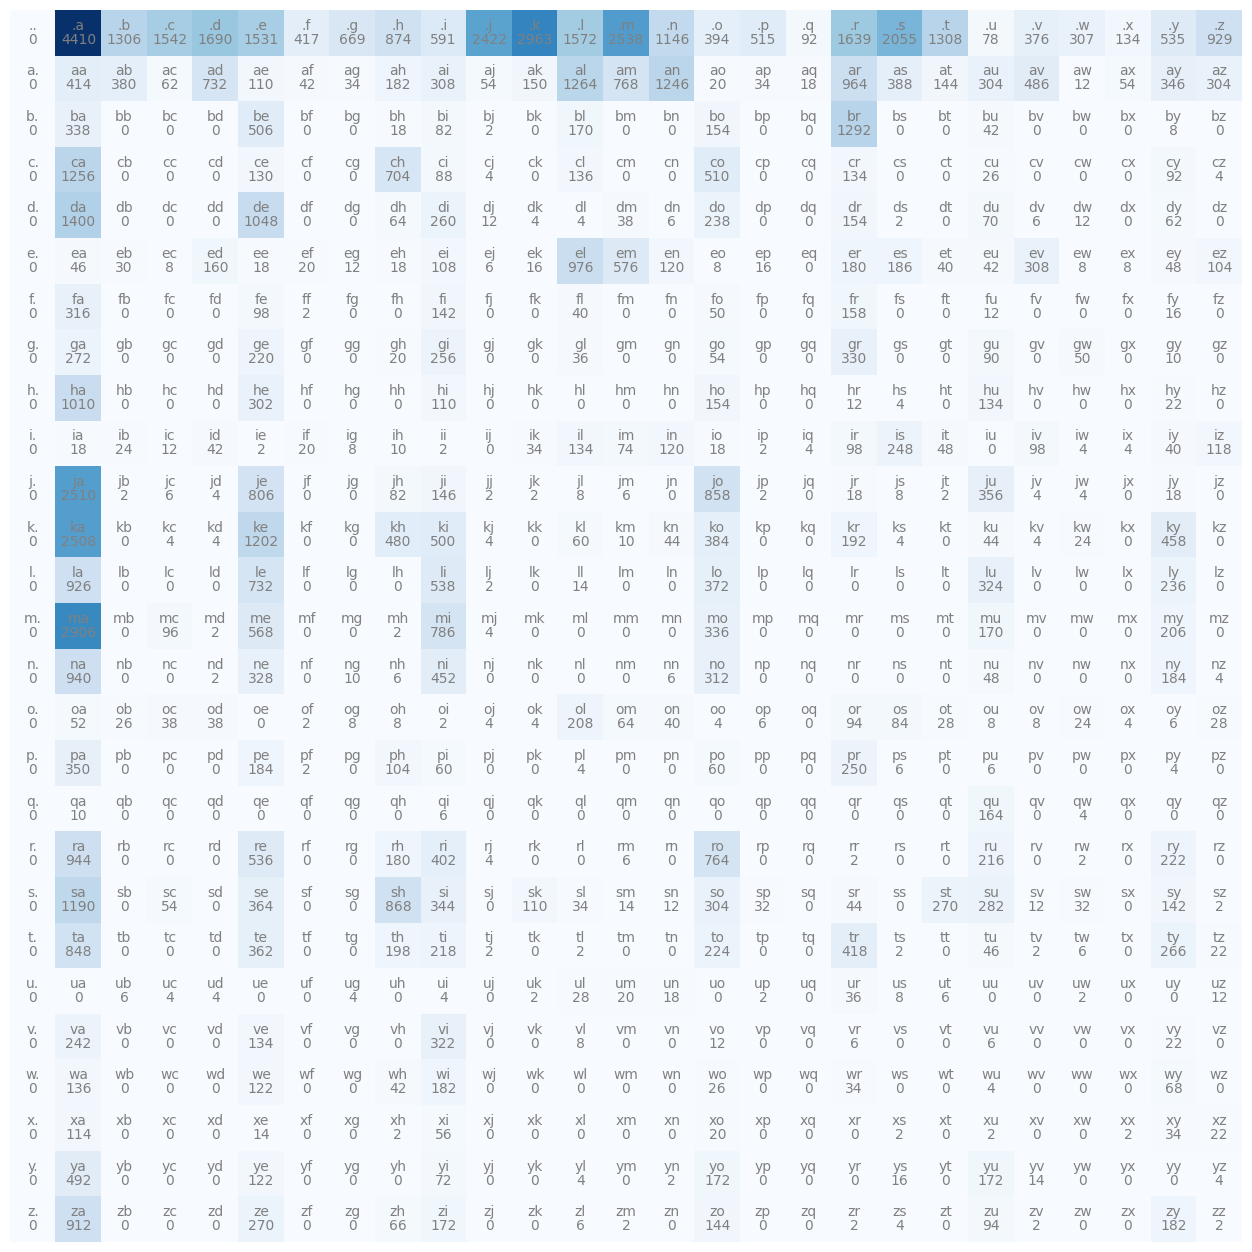

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N[0], cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[0,i,j].item(), ha='center', va='top', color='gray')
plt.axis("off")

In [18]:
p = N[0][1].float()
p = p / p.sum()
p

tensor([0.0000, 0.0469, 0.0431, 0.0070, 0.0830, 0.0125, 0.0048, 0.0039, 0.0206,
        0.0349, 0.0061, 0.0170, 0.1433, 0.0871, 0.1413, 0.0023, 0.0039, 0.0020,
        0.1093, 0.0440, 0.0163, 0.0345, 0.0551, 0.0014, 0.0061, 0.0392, 0.0345])

In [19]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix

4

In [20]:
P = (N + 1).float()
P = P / P.sum(2, keepdim=True)

In [22]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    ix1 = 0
    ix2 = 0
    out = []
    while True:
        p = P[ix1, ix2]
        ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1, ix2 = ix2, ix3

    print(''.join(out))

kaybdifellian.
elmaxton.
dee.
meigh.
col.
eve.
masinernaist.
kio.
man.
wreesa.


In [23]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1][ix2][ix3]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
print(log_likelihood)
nll = -log_likelihood
print(nll/n)

tensor(-502089.4062)
tensor(2.2007)


In [24]:
#create training set
xs, zs, ys = [], [], []

for w in words[:1]:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append(ix1)
        zs.append(ix2)
        ys.append(ix3)

xs = torch.tensor(xs)
zs = torch.tensor(zs)
ys = torch.tensor(ys)


In [34]:
import torch.nn.functional as F
x1 = F.one_hot(xs, num_classes=27).float()
x2 = F.one_hot(zs, num_classes=27).float()
xenc = torch.cat([x1, x2], dim=1).float()

In [35]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g)

In [36]:
xenc.shape

torch.Size([5, 54])

In [37]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)  #NEED TO BE CLEAR, SOFTMAX

tensor([ 0,  5, 13, 13,  1])

In [67]:
#create training set
xs, zs, ys = [], [], []

for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append(ix1)
        zs.append(ix2)
        ys.append(ix3)

xs = torch.tensor(xs)
zs = torch.tensor(zs)
ys = torch.tensor(ys)
num = xs.nelement()
print("num of examples: ", num)

#init network
#init NN weights 27
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)


num of examples:  228146


In [72]:
for k in range(1000):
    #forward pass
    x1 = F.one_hot(xs, num_classes=27).float()
    x2 = F.one_hot(zs, num_classes=27).float()
    xenc = torch.cat([x1, x2], dim=1).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/ counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean()
    print(loss.item())

    #backward pass
    W.grad = None
    loss.backward()

    #update weights
    W.data += -1*W.grad

2.401962995529175
2.4019315242767334
2.401899814605713
2.4018681049346924
2.401836633682251
2.4018051624298096
2.4017739295959473
2.401742458343506
2.4017109870910645
2.401679754257202
2.40164852142334
2.4016170501708984
2.401585817337036
2.4015543460845947
2.4015231132507324
2.40149188041687
2.401460647583008
2.4014296531677246
2.4013984203338623
2.401367425918579
2.401336193084717
2.4013051986694336
2.4012742042541504
2.4012434482574463
2.401212453842163
2.40118145942688
2.4011504650115967
2.4011194705963135
2.4010887145996094
2.4010581970214844
2.401027202606201
2.400996446609497
2.400965929031372
2.400935173034668
2.4009041786193848
2.400873899459839
2.4008431434631348
2.4008123874664307
2.4007816314697266
2.4007513523101807
2.4007205963134766
2.4006905555725098
2.4006597995758057
2.4006295204162598
2.4005990028381348
2.400568723678589
2.400538206100464
2.400507688522339
2.400477647781372
2.4004476070404053
2.4004170894622803
2.4003868103027344
2.4003565311431885
2.4003264904022217

In [66]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix1, ix2 = 0, 0
    while True:
        x1 = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        x2 = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        xenc = torch.cat([x1, x2], dim=1).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)

        ix3 = torch.multinomial(p[0], num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1, ix2 = ix2, ix3

    print(''.join(out))


cexze.
morlyurailaziaydamellimittain.
lusan.
ka.
da.


In [63]:
p.shape

torch.Size([228146, 27])